## Working with OOI NetCDF Data

In this example we show how to work with the data downloaded via the netcdf_data_requests notebook. Go there first to understand how data is requested from the system and downloaded to a thredds server for retrieval, before proceeding with this notebook.

We will use data from the 3D Thermistory Array deployed in the ASHES Vent field at Axial Seamount for this example, but the mechanics apply to all datasets that are processed through the OOI Cyberinfrastructure (CI) system. You wil learn:

* how to load the NetCDF data into your notebook, once the data request has completed (see notebook netcdf_data_requests)
* how to explore and plot data


A great resource for data wrangling and exploration in python can be found at https://chrisalbon.com/. Tip: add "albon" to your search in google when trying to find a common technique and chances are Chris Albon has made a post on how to do it.

For this example, we are using data from the 3D Thermistor Array (TMPSF)
http://ooi.visualocean.net/instruments/view/RS03ASHS-MJ03B-07-TMPSFA301

![RS03ASHS-MJ03B-07-TMPSFA301](../../../images/RS03ASHS-MJ03B-07-TMPSFA301.png)

## Loading the data into the notebook.

In [3]:
import requests
import re
import xarray as xr
import pandas as pd
import os

Paste the thredds url you received by downloading the data from the netcdf_data_requests notebook, or use the one provided below.  

We will parse the html at the location where the files are being delivered to get the list of the NetCDF files written to THREDDS. Note that seperate NetCDF files are created at 500 mb intervals and when there is a new deployment.

In [4]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180221T030103-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]

In [5]:
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180221T030103-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0003_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20170815T003130.804600-20180221T030100.749868.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180221T030103-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0001_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20160829T000001.097642-20170813T232226.349596.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180221T030103-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0001_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20140929T190312-20160828T235949.096897.nc']

Use xarray to open all netcdf files as a single xarray datase, swap the dimention from obs to time and and examine the content.

In [6]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds = ds.chunk({'time': 100})
ds

<xarray.Dataset>
Dimensions:              (time: 10808216)
Coordinates:
    obs                  (time) int64 dask.array<shape=(10808216,), chunksize=(100,)>
  * time                 (time) datetime64[ns] 2017-08-15T00:31:30.804600320 ...
    lat                  (time) float64 dask.array<shape=(10808216,), chunksize=(100,)>
    lon                  (time) float64 dask.array<shape=(10808216,), chunksize=(100,)>
Data variables:
    deployment           (time) int32 dask.array<shape=(10808216,), chunksize=(100,)>
    id                   (time) |S64 dask.array<shape=(10808216,), chunksize=(100,)>
    battery_voltage      (time) float32 dask.array<shape=(10808216,), chunksize=(100,)>
    driver_timestamp     (time) datetime64[ns] dask.array<shape=(10808216,), chunksize=(100,)>
    ingestion_timestamp  (time) datetime64[ns] dask.array<shape=(10808216,), chunksize=(100,)>
    internal_timestamp   (time) datetime64[ns] dask.array<shape=(10808216,), chunksize=(100,)>
    port_timestamp       

## Exploring the data.

In [8]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np

Use built in xarray plotting functions to create simple line plot.

/Users/knuth/miniconda2/envs/ooi2/lib/python2.7/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


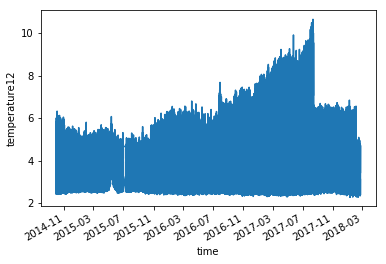

In [9]:
ds['temperature12'].plot()
plt.show()

We can tell that the peak temperature is increatsing, but this simple line plot does not reveal the internal data distribution. Let's convert to pandas dataframe and downsample from 1 Hz to 1/60 Hz. This step may take 5-10 minutes. More ram will be allocated during the workshop to expedite processing. If the step fails entirely for any reason, please send us a note on slack.

In [10]:
%%time
from dask.diagnostics import ProgressBar
with ProgressBar():
    df = ds['temperature12'].to_dataframe()
    df = df.resample('min').mean()

CPU times: user 2min 13s, sys: 1min 32s, total: 3min 46s
Wall time: 13min 39s


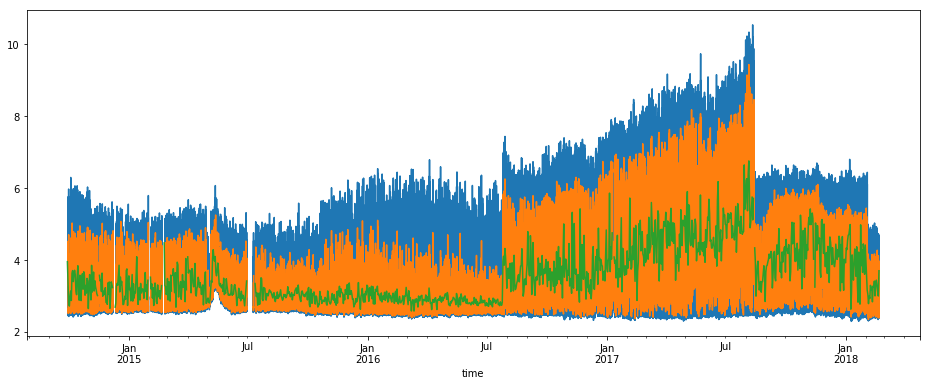

CPU times: user 9.21 s, sys: 682 ms, total: 9.9 s
Wall time: 9.24 s


In [12]:
%%time
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
df['temperature12'].plot(ax=ax)
df['temperature12'].resample('H').mean().plot(ax=ax)
df['temperature12'].resample('D').mean().plot(ax=ax)
plt.show()

Now we are getting a better sense of the data. Let's convert time to ordinal, grab temperature values and re-examine using hexagonal bi-variate binning. Again, this step may take a few minutes, but should run faster during the workshop. If the step fails entirely for any reason, please send us a note on slack.

In [13]:
%%time
time = []
time_pd = pd.to_datetime(ds.time.values.tolist())
for i in time_pd:
    i = np.datetime64(i).astype(datetime.datetime)
    time.append(dates.date2num(i)) 

CPU times: user 2min 9s, sys: 6.96 s, total: 2min 16s
Wall time: 2min 12s


In [14]:
temperature = ds['temperature12'].values.tolist()

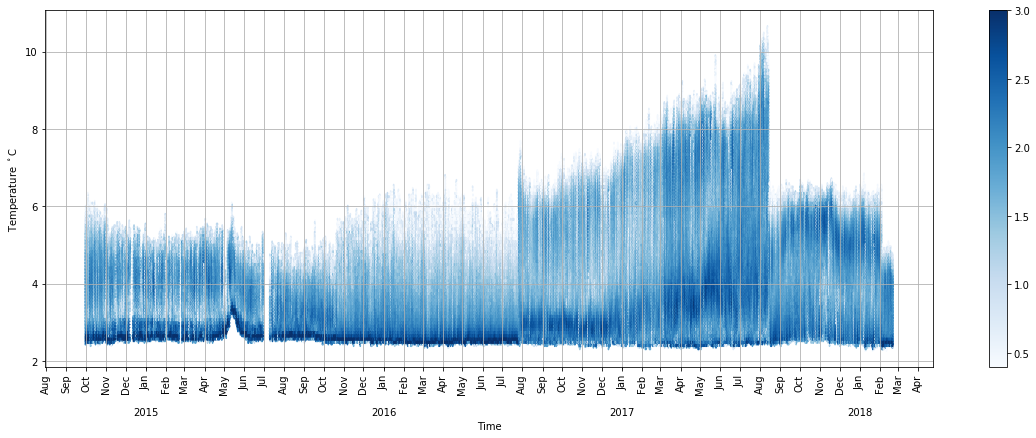

In [15]:
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

hb1 = ax.hexbin(time, temperature, bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Blues')
fig.colorbar(hb1)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
# ax.set_xlim(datetime.datetime(2015, 12, 1, 0, 0),datetime.datetime(2016, 7, 25, 0, 0))
# ax.set_ylim(2,11)
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(years)
ax.xaxis.set_minor_formatter(yearsFmt)
plt.tight_layout()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.ylabel('Temperature $^\circ$C')
plt.xlabel('Time')
plt.show()